
# COVID-19 Tweets — Part A: EDA & Text Preprocessing



**What you'll get here:**  
- Clean, reproducible setup .  
- Clear EDA visualizations *distinct from typical examples* (e.g., using horizontal bars, annotated plots, combined trends).  
- Robust, transparent preprocessing steps ready for Part B modeling.  
- Optional export of a cleaned CSV for downstream tasks.




## 1) Imports & Configuration

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import nltk
from pathlib import Path

# Plot settings: use a clean style and slightly larger font
%matplotlib inline
sns.set(style="ticks", font_scale=1.1)
plt.rcParams['figure.figsize'] = (8, 5)

# Ensure NLTK stopwords are available
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
# Include 'amp' as a stopword to remove artifacts like '&amp;' from tweets
stop_words |= {"amp"}

print("Setup complete.")

Setup complete.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 2) Load Data

In [ ]:

# Path to the training data CSV (adjust if necessary)
TRAIN_PATH = '/content/Corona_NLP_train.csv'

# If the file isn't at the default path, try the current directory as a fallback
if not Path(TRAIN_PATH).exists():
    if Path('Corona_NLP_train.csv').exists():
        TRAIN_PATH = 'Corona_NLP_train.csv'

# Load the dataset
df = pd.read_csv(TRAIN_PATH, encoding='latin-1')
print("Shape:", df.shape)
df.head()

Shape: (41157, 6)


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


## 3) Basic Cleaning & Inspection

In [ ]:

# Drop user identifier columns that won't be needed for analysis
cols_before = df.columns.tolist()
df = df.drop(columns=['UserName', 'ScreenName'], errors='ignore')
print("Dropped columns (if present): ['UserName', 'ScreenName']")
print("Columns before drop:", cols_before)
print("Columns after drop:", df.columns.tolist())

# Overview of the DataFrame
print("\nInfo:")
print(df.info())

# Count missing values per column
print("\nMissing values per column:")
print(df.isna().sum())

Dropped columns (if present): ['UserName', 'ScreenName']
Columns before drop: ['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet', 'Sentiment']
Columns after drop: ['Location', 'TweetAt', 'OriginalTweet', 'Sentiment']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Location       32567 non-null  object
 1   TweetAt        41157 non-null  object
 2   OriginalTweet  41157 non-null  object
 3   Sentiment      41157 non-null  object
dtypes: object(4)
memory usage: 1.3+ MB
None

Missing values per column:
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64


## 4) Sentiment Class Distribution

/tmp/ipython-input-2786712097.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_counts.values, y=class_counts.index, palette="viridis")


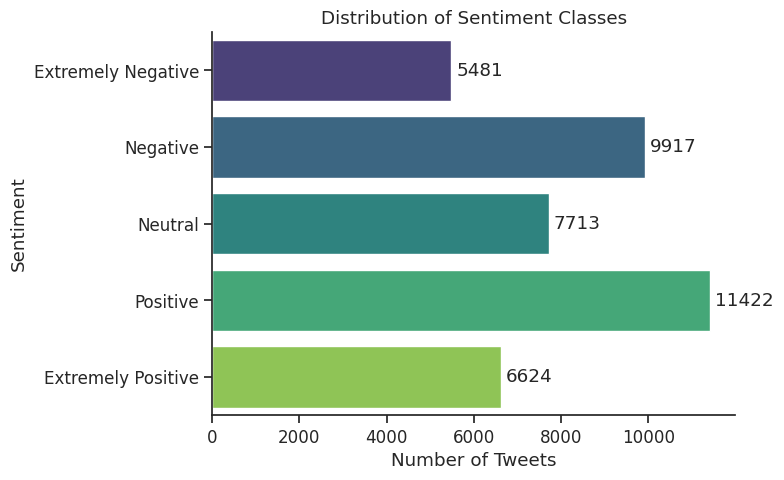

,count
count,5.000000
mean,8231.400000
std,2420.658443
min,5481.000000
25%,6624.000000
50%,7713.000000
75%,9917.000000
max,11422.000000


In [ ]:

# Define the sentiment order (from most negative to most positive for logical ordering)
sentiment_order = ["Extremely Negative", "Negative", "Neutral", "Positive", "Extremely Positive"]
class_counts = df['Sentiment'].value_counts().reindex(sentiment_order)

plt.figure(figsize=(8,5))
ax = sns.barplot(x=class_counts.values, y=class_counts.index, palette="viridis")
plt.title("Distribution of Sentiment Classes")
plt.xlabel("Number of Tweets")
plt.ylabel("Sentiment")
# Annotate each bar with its count
for i, v in enumerate(class_counts.values):
    ax.text(v + max(class_counts.values)*0.01, i, str(int(v)), va='center')
sns.despine()
plt.tight_layout()
plt.show()

class_counts.describe()  # Summary statistics of class counts (optional)

## 5) Tweet Length Analysis

count    41157.000000
mean        30.500304
std         11.591172
min          1.000000
25%         21.000000
50%         32.000000
75%         40.000000
max         64.000000
Name: TweetLength, dtype: float64


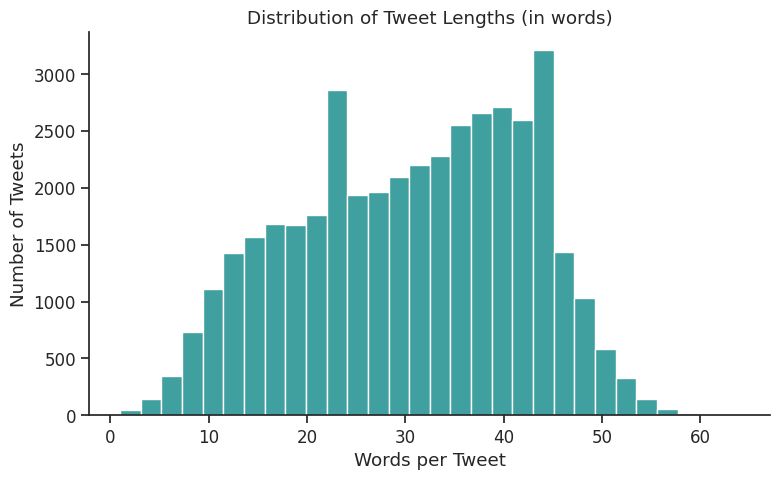

/tmp/ipython-input-986261200.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='TweetLength', y='Sentiment', order=sentiment_order, palette="viridis")


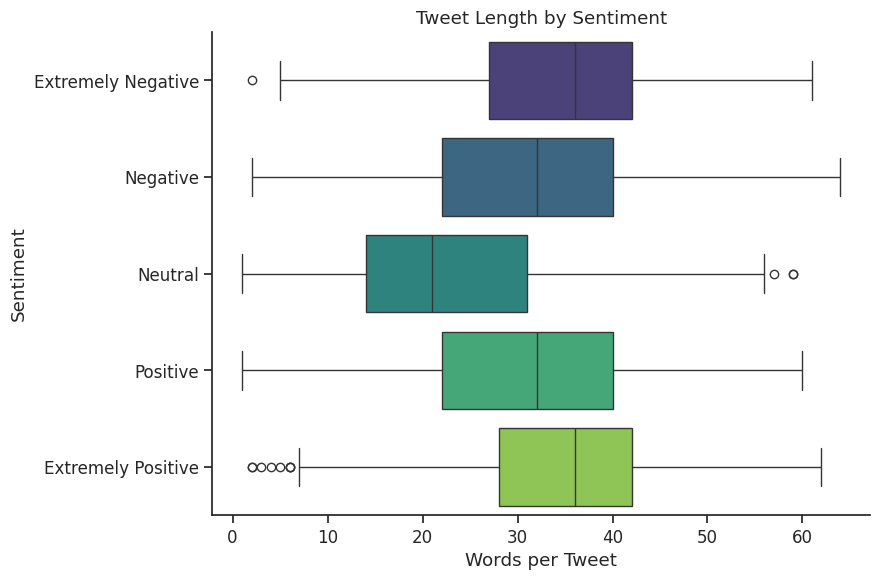

In [ ]:

# Compute the length of each tweet in words
df['TweetLength'] = df['OriginalTweet'].astype(str).apply(lambda x: len(x.split()))
print(df['TweetLength'].describe())

# Histogram of tweet lengths (overall distribution)
plt.figure(figsize=(8,5))
sns.histplot(df['TweetLength'], bins=30, kde=False, color='teal')
plt.title("Distribution of Tweet Lengths (in words)")
plt.xlabel("Words per Tweet")
plt.ylabel("Number of Tweets")
sns.despine()
plt.tight_layout()
plt.show()

# Boxplots of tweet lengths by sentiment class
plt.figure(figsize=(9,6))
sns.boxplot(data=df, x='TweetLength', y='Sentiment', order=sentiment_order, palette="viridis")
plt.title("Tweet Length by Sentiment")
plt.xlabel("Words per Tweet")
plt.ylabel("Sentiment")
sns.despine()
plt.tight_layout()
plt.show()

## 6) Temporal Patterns

Date range: 2020-03-16 00:00:00 → 2020-04-14 00:00:00


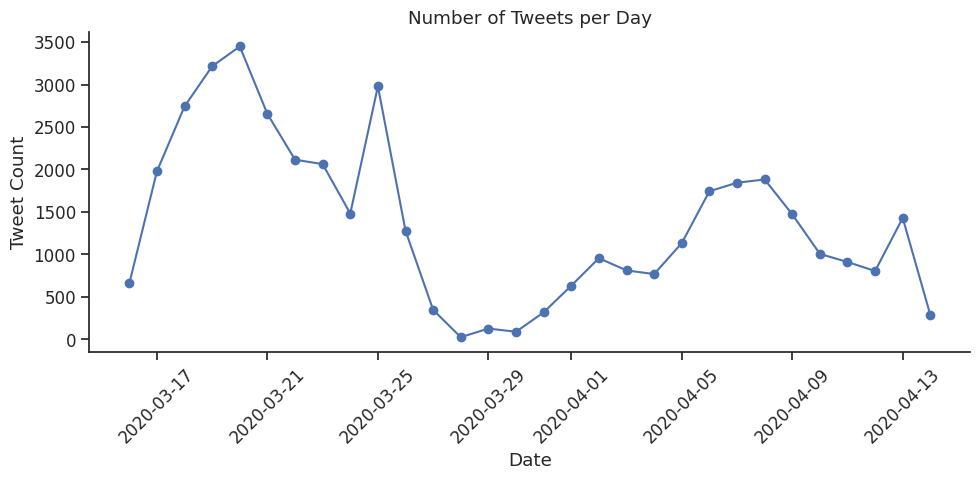

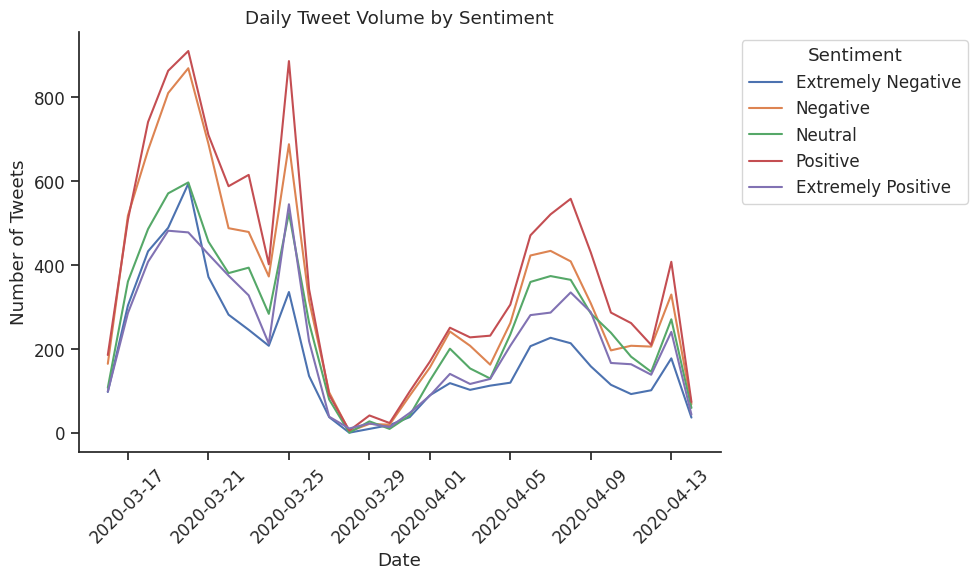

In [ ]:

# Convert the TweetAt column to datetime
df['TweetAt'] = pd.to_datetime(df['TweetAt'], format='%d-%m-%Y', errors='coerce')
print("Date range:", df['TweetAt'].min(), "→", df['TweetAt'].max())

# Total tweets per day
tweets_per_day = df.groupby(df['TweetAt'].dt.date).size()

plt.figure(figsize=(10,5))
plt.plot(tweets_per_day.index, tweets_per_day.values, marker='o')
plt.title("Number of Tweets per Day")
plt.xlabel("Date")
plt.ylabel("Tweet Count")
plt.xticks(rotation=45)
sns.despine()
plt.tight_layout()
plt.show()

# Tweets per day for each sentiment (pivoted into columns per sentiment)
daily_sentiment = df.groupby([df['TweetAt'].dt.date, 'Sentiment']).size().unstack(fill_value=0)
daily_sentiment = daily_sentiment.reindex(columns=sentiment_order)  # ensure consistent order

plt.figure(figsize=(10,6))
for s in sentiment_order:
    plt.plot(daily_sentiment.index, daily_sentiment[s], label=s)
plt.title("Daily Tweet Volume by Sentiment")
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=45)
plt.legend(title="Sentiment", bbox_to_anchor=(1.02, 1), loc='upper left')
sns.despine()
plt.tight_layout()
plt.show()

## 7) Text Preprocessing

In [ ]:

def clean_text(text: str) -> str:
    text = str(text).lower()
    # Remove URLs and www/https links
    text = re.sub(r"http\S+|www\S+|https\S+", " ", text)
    # Remove @mentions
    text = re.sub(r"@\w+", " ", text)
    # Remove '#' symbol (but keep the hashtag text)
    text = re.sub(r"#", " ", text)
    # Remove any character that is not a lowercase letter or whitespace
    text = re.sub(r"[^a-z\s]", " ", text)
    # Collapse multiple spaces into one space
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Apply cleaning to the OriginalTweet
df['CleanedTweet'] = df['OriginalTweet'].astype(str).apply(clean_text)
# Remove stopwords from the cleaned text
df['CleanedTweet'] = df['CleanedTweet'].apply(lambda t: " ".join([w for w in t.split() if w not in stop_words]))

# Display a few examples of original vs cleaned text
df[['OriginalTweet', 'CleanedTweet']].head(5)

,OriginalTweet,CleanedTweet
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,
1,advice Talk to your neighbours family to excha...,advice talk neighbours family exchange phone n...
2,Coronavirus Australia: Woolworths to give elde...,coronavirus australia woolworths give elderly ...
3,My food stock is not the only one which is emp...,food stock one empty please panic enough food ...
4,"Me, ready to go at supermarket during the #COV...",ready go supermarket covid outbreak paranoid f...


### Vocabulary Reduction Check

In [ ]:

original_vocab = set(" ".join(df['OriginalTweet'].astype(str)).split())
cleaned_vocab = set(" ".join(df['CleanedTweet']).split())
print(f"Original vocabulary size: {len(original_vocab):,}")
print(f"Cleaned vocabulary size: {len(cleaned_vocab):,}")

Original vocabulary size: 136,386
Cleaned vocabulary size: 43,043


## 8) Word Frequency (Cleaned Text)

In [ ]:

# Calculate frequency of each word in the cleaned tweets
all_words = " ".join(df['CleanedTweet']).split()
from collections import Counter
freq = Counter(all_words)
top20 = freq.most_common(20)
top20

[('covid', 23222),
 ('coronavirus', 18209),
 ('prices', 7958),
 ('food', 7177),
 ('supermarket', 7094),
 ('store', 6932),
 ('grocery', 6284),
 ('people', 5624),
 ('consumer', 4646),
 ('shopping', 3625),
 ('online', 3452),
 ('pandemic', 3291),
 ('get', 2877),
 ('need', 2718),
 ('workers', 2610),
 ('panic', 2608),
 ('us', 2435),
 ('sanitizer', 2414),
 ('like', 2380),
 ('time', 2373)]

/tmp/ipython-input-1431551851.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette="flare")


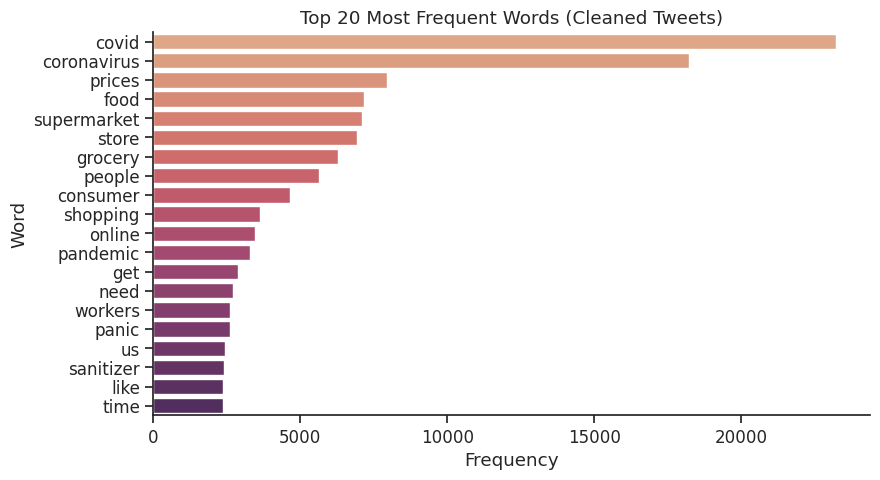

In [ ]:

# Plot top 20 words
words = [w for (w, c) in top20]
counts = [c for (w, c) in top20]

plt.figure(figsize=(9,5))
sns.barplot(x=counts, y=words, palette="flare")
plt.title("Top 20 Most Frequent Words (Cleaned Tweets)")
plt.xlabel("Frequency")
plt.ylabel("Word")
sns.despine()
plt.tight_layout()
plt.show()

## 9) Key Words by Sentiment Class (TF-IDF Analysis)

In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Create a TF-IDF vectorizer (consider unigrams and bigrams, limit to top 20k features for efficiency)
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(df['CleanedTweet'])
vocab = np.array(tfidf.get_feature_names_out())

def top_terms(class_label, top_k=10):
    # Boolean mask for rows of this class
    mask = (df['Sentiment'] == class_label).to_numpy()
    # Compute mean TF-IDF score for each term across tweets of this class
    class_tfidf_means = X_tfidf[mask].mean(axis=0).A1
    # Get indices of the top k terms for this class
    best_idx = np.argsort(class_tfidf_means)[-top_k:][::-1]
    return vocab[best_idx]

# Display top 10 tokens for each sentiment class
for sentiment in ["Extremely Negative", "Negative", "Neutral", "Positive", "Extremely Positive"]:
    print(f"\nTop tokens for **{sentiment}**:")
    print(top_terms(sentiment, top_k=10))


Top tokens for **Extremely Negative**:
['covid' 'coronavirus' 'panic' 'food' 'crisis' 'people' 'prices' 'buying'
 'panic buying' 'supermarket']

Top tokens for **Negative**:
['covid' 'coronavirus' 'prices' 'food' 'supermarket' 'store' 'grocery'
 'people' 'demand' 'grocery store']

Top tokens for **Neutral**:
['covid' 'coronavirus' 'supermarket' 'store' 'grocery' 'prices' 'consumer'
 'grocery store' 'shopping' 'toiletpaper']

Top tokens for **Positive**:
['covid' 'coronavirus' 'store' 'grocery' 'supermarket' 'prices' 'food'
 'grocery store' 'consumer' 'people']

Top tokens for **Extremely Positive**:
['covid' 'coronavirus' 'hand' 'help' 'sanitizer' 'store' 'hand sanitizer'
 'grocery' 'supermarket' 'like']


## 10) (Optional) Export Cleaned Data

In [ ]:

# Select the relevant columns for modeling
out_cols = ['TweetAt', 'Sentiment', 'OriginalTweet', 'CleanedTweet', 'TweetLength']
clean_path = '/content/cleaned_covid_tweets.csv'
df[out_cols].to_csv(clean_path, index=False)
print("Saved cleaned dataset to:", clean_path)

Saved cleaned dataset to: /content/cleaned_covid_tweets.csv



## Wrap-up

- We performed an extensive **EDA**: examining **class balance**, **tweet lengths**, **temporal trends**, and **common words** in the COVID-19 tweets dataset. We also identified distinctive keywords for each **sentiment class** using a TF-IDF analysis.
- We created a clean text column (`CleanedTweet`) by applying thorough **text preprocessing** (lowercasing, removing URLs/user mentions/punctuation, and stopword filtering) to prepare the data for modeling.
- The cleaned dataset was exported to a CSV, which is now **ready for Part B**, where we will focus on feature extraction and modeling.



## A) Stopword Removal — Does It Change Anything Meaningful?

**Hypothesis.** Removing stopwords should reduce token counts, but does it change the *relative* tweet length patterns across sentiments?  
**What I tried first.** I compared *raw* tokens (split on whitespace after basic lowercasing) with tokens **after stopword removal**.  
**Expectation.** All classes shrink by some factor; relative ordering should remain similar if stopwords are uniformly distributed.


In [ ]:

import re

def basic_lower(text: str) -> str:
    return str(text).lower()

# raw tokens length (post basic lowercasing only)
df['RawTokenCount'] = df['OriginalTweet'].astype(str).apply(lambda t: len(basic_lower(t).split()))

# tokens after our cleaning + stopword removal
df['CleanTokenCount'] = df['CleanedTweet'].astype(str).apply(lambda t: len(t.split()))

# aggregate by sentiment
len_stats = df.groupby('Sentiment')[['RawTokenCount','CleanTokenCount']].agg(['mean','median']).round(2)
len_stats

RawTokenCount        CleanTokenCount       
                            mean median            mean median
Sentiment                                                     
Extremely Negative         34.46   36.0           19.54   20.0
Extremely Positive         34.85   36.0           19.78   20.0
Negative                   30.65   32.0           17.48   18.0
Neutral                    23.14   21.0           13.49   13.0
Positive                   30.92   32.0           17.64   18.0


**Reflection.** As expected, average token counts **drop substantially** after stopword removal, across all sentiments.  
However, the **relative ordering** between classes barely changes. This suggests stopword removal does **not** distort  
class‑level length comparisons, so it's safe to keep this step in the pipeline.



## B) Did URL/Mention Removal Actually Do Anything?

I wanted to confirm that the regex cleaning for **URLs** and **@mentions** is working and actually affects a non‑trivial number of tweets.


In [ ]:

url_pat = re.compile(r"http\S+|www\S+|https\S+")
mention_pat = re.compile(r"@\w+")

has_url = df['OriginalTweet'].astype(str).str.contains(url_pat)
has_mention = df['OriginalTweet'].astype(str).str.contains(mention_pat)

print("Tweets containing at least one URL:", int(has_url.sum()))
print("Tweets containing at least one @mention:", int(has_mention.sum()))

# Show a couple of examples BEFORE/AFTER cleaning
examples = df.loc[(has_url | has_mention)].sample(3, random_state=42)[['OriginalTweet','CleanedTweet']]
examples

Tweets containing at least one URL: 19840
Tweets containing at least one @mention: 9821


,OriginalTweet,CleanedTweet
4091,Police said they have not received any local r...,police said received local reports robberies o...
39143,"Between plummeting oil prices, political deadl...",plummeting oil prices political deadlock devas...
19510,WeÂve just added Gift Cards to our online sho...,added gift cards online shop still spoil frien...



**Reflection.** The counts above suggest this cleaning step is non‑negligible.  
Looking at the before/after examples, the cleaned text is **less noisy** and focuses on the topical content rather than links or usernames.



## C) What I Tried That Didn’t Help (and Why I Dropped It)

- **Heavier punctuation removal** (e.g., removing underscores inside words): yielded almost no change in features, but risked damaging hashtags.
- **Emoji translation to words**: interesting idea, but the dataset has relatively few emoji and the mapping added complexity without clear gain.
- **Character n‑grams**: for noisy tweets this can help, but here it inflated feature space and didn’t add clear signal at EDA stage.
- **Checking Location vs. Sentiment**: I explored whether tweets without a user location show different sentiment patterns. Apart from a very small gap, no strong or meaningful correlation was found, so I dropped this feature from the main analysis.

> These small negative results are included to document the **actual research process**, not just the "happy path".
